## TF Lite Breast Cancer Detection Week 6: Develop First Modeling Approach
### Yinda Chen and Alice Tang

This week's notebook will focus on developing our first modeling approach. For this week, we have chosen the CNN model. 

We also want to preface that this notebook will unfortunately not run on JupyterHub due to environmental constraints. We had issues with uploading the entire image dataset on JupyterHub, and we did not think training on a subset of data would generate sufficient results. Furthermore, we do plan on taking this model and building a TFLite application, so we wanted to be sure we trained on as much data as possible and create the best model we can.

We've used the free GPU P100 on Kaggle to run this notebook. It takes around 15 minutes.

#### The link to the Kaggle Notebook is here, and can be run directly from this link: https://www.kaggle.com/code/alicetangs/model-approach-1/notebook?scriptVersionId=200930257

#### Let's get started, shall we?

To preface, the dataset can be found here: https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset.

In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Importing needed packages
import pandas as pd
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import re

from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from sklearn.model_selection import train_test_split

In [3]:
# Loading the datasets
calc_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')
dicom_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')

In [4]:
# Change the directory in the dicom_info.csv in order to load the imgs correctly
image_dir = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/'
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
roi_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path

full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
roi_mask_images = roi_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images.head()

1     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
2     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
11    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
12    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
15    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
Name: image_path, dtype: object

Beginning with cleaning the dicom_data.

In [5]:
dicom_cleaning_data = dicom_data.copy()
dicom_cleaning_data['image_path'] = dicom_cleaning_data['image_path'].str.replace('CBIS-DDSM/jpeg/', image_dir)

In [6]:
dicom_cleaning_data.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True)
dicom_cleaning_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   file_path                                    10237 non-null  object
 1   image_path                                   10237 non-null  object
 2   BitsAllocated                                10237 non-null  int64 
 3   BitsStored                                   10237 non-null  int64 
 4   BodyPartExamined                             10237 non-null  object
 5   ConversionType                               10237 non-null  object
 6   HighBit                                      10237 non-null  int64 
 7   LargestImagePixelValue                       10237 non-null  int64 
 8   Laterality                                   9671 non-null   object
 9   Modality                                     10237 non-null  object
 10  PatientID 

In [7]:
dicom_cleaning_data['SeriesDescription'].fillna(0, axis = 0, inplace=True)
dicom_cleaning_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)

dicom_cleaning_data.isna().sum()

/tmp/ipykernel_30/3411754779.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dicom_cleaning_data['SeriesDescription'].fillna(0, axis = 0, inplace=True)
/tmp/ipykernel_30/3411754779.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet

In [8]:
# Mapping the labels
label_mapping = {'BENIGN': 0, 'MALIGNANT': 1, 'BENIGN_WITHOUT_CALLBACK': 2}
calc_train['label'] = calc_train['pathology'].map(label_mapping)
calc_test['label'] = calc_test['pathology'].map(label_mapping)
mass_train['label'] = mass_train['pathology'].map(label_mapping)
mass_test['label'] = mass_test['pathology'].map(label_mapping)

In [9]:
# Creating our functions to load and process mammograms, focusing on all 3 types of images (full mammogram, cropped images, ROI mask)

dicom_model = dicom_data.copy()
dicom_model['image_path'] = dicom_cleaning_data['image_path'].str.replace('CBIS-DDSM/jpeg/', image_dir)

def load_and_process_image(image_path):
    image = load_img(image_path, target_size=(224,224), color_mode="grayscale")
    image = img_to_array(image) / 255.0
    return image


def match1(file_path):
    patientID = file_path.split('/')[0]
    series_description = 'full mammogram images'
    filtered_df = dicom_cleaning_data[(dicom_cleaning_data['SeriesDescription'] == series_description) & 
                            (dicom_cleaning_data['PatientName'] == patientID)]

    if filtered_df.empty:
        return None
    #print(1)
    return filtered_df['image_path'].iloc[0]

def match2(file_path):
    patientID = file_path.split('/')[0]
    series_description = 'cropped images'
    filtered_df = dicom_cleaning_data[(dicom_cleaning_data['SeriesDescription'] == series_description) & 
                            (dicom_cleaning_data['PatientName'] == patientID)]
    if filtered_df.empty:
        return None
    #print(2)
    return filtered_df['image_path'].iloc[0]

def match3(file_path):
    patientID = file_path.split('/')[0]
    series_description = 'ROI mask images'

    filtered_df = dicom_cleaning_data[(dicom_cleaning_data['SeriesDescription'] == series_description) & 
                            (dicom_cleaning_data['PatientName'] == patientID)]
    if filtered_df.empty:
        print('no')
        return None
    #print(3)
    return filtered_df['image_path'].iloc[0]
def load_data(df):
    full_imgs = []
    cropped_imgs = []
    roi_imgs = []
    labels = []
    for _, row in df.iterrows():
        full_img_path = match1(row['image file path'])
        if full_img_path is None:
            continue
        cropped_img_path = match2(row['cropped image file path'])
        if cropped_img_path is None:
            continue
        roi_img_path = match3(row['ROI mask file path'])
        if roi_img_path is None:
            continue
        # roi_img_path = match4(row['ROI mask file path'])
        # if roi_img_path is None:
        #     continue

        if full_img_path is not None and cropped_img_path is not None and roi_img_path is not None:
            if os.path.exists(full_img_path) and os.path.exists(cropped_img_path) and os.path.exists(roi_img_path):
                full_imgs.append(load_and_process_image(full_img_path))
                cropped_imgs.append(load_and_process_image(cropped_img_path))
                roi_imgs.append(load_and_process_image(roi_img_path))
                labels.append(row['label'])
            

    return np.array(full_imgs), np.array(cropped_imgs), np.array(roi_imgs), np.array(labels)

Next, we'll need to prepare the data to ensure only unique images are included in the modeling.

First, we'll determine how many unique image file paths exist in calc_train/test, mass_train/test, and then remove any rows that have duplicate image file paths. Then we'll print the unique image file paths remain after the duplicates are removed.

In [10]:
# First, for calc_train.
calc_train['image file path'].nunique()
calc_train_model = calc_train.copy()
calc_train_model = calc_train_model.drop_duplicates(subset=['image file path']).reset_index(drop=True)
calc_train_model['image file path'].nunique()

1227

In [11]:
# Next, mass_train.
print(mass_train['image file path'].nunique())
mass_train_model = mass_train.copy()
mass_train_model = mass_train_model.drop_duplicates(subset=['image file path']).reset_index(drop=True)
mass_train_model['image file path'].nunique()

1231


1231

In [12]:
# Then, mass_test.
print(mass_test['image file path'].nunique())
mass_test_model = mass_test.copy()
mass_test_model = mass_test_model.drop_duplicates(subset=['image file path']).reset_index(drop=True)
mass_test_model['image file path'].nunique()

361


361

In [13]:
# Lastly, calc_test.
print(calc_test['image file path'].nunique())
calc_test_model = calc_test.copy()
calc_test_model = calc_test_model.drop_duplicates(subset=['image file path']).reset_index(drop=True)
calc_test_model['image file path'].nunique()

284


284

In [14]:
# Checking the info to confirm.
calc_train_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227 entries, 0 to 1226
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1227 non-null   object
 1   breast density           1227 non-null   int64 
 2   left or right breast     1227 non-null   object
 3   image view               1227 non-null   object
 4   abnormality id           1227 non-null   int64 
 5   abnormality type         1227 non-null   object
 6   calc type                1219 non-null   object
 7   calc distribution        1027 non-null   object
 8   assessment               1227 non-null   int64 
 9   pathology                1227 non-null   object
 10  subtlety                 1227 non-null   int64 
 11  image file path          1227 non-null   object
 12  cropped image file path  1227 non-null   object
 13  ROI mask file path       1227 non-null   object
 14  label                    1227 non-null  

Here, we're trying to verify the paths and labels are correctly matched and accessible for a specific patient in the dataset. We then retrieve and print the full mammogram image path, cropped image path, and ROI mask image path for the specific patient (index 1000). It then finds the corresponding label for that patient, which will be used for analysis or modeling purposes.

In [15]:
print(match1(calc_train_model['image file path'][1000]))
print(match2(calc_train_model['cropped image file path'][1000]))
print(match3(calc_train_model['ROI mask file path'][1000]))
calc_train_model['label'][1000]

/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.137562241011481380706391312851646232919/1-188.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.229884593710867275129805277951021683949/1-100.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.229884593710867275129805277951021683949/2-077.jpg


2

Here, we will begin preparing to load and processs the full, cropped, and ROI mask images along with their labels from the calc_train_model df. We then check the shape of the full images array to understand the size of the training dataset, this will help with the modeling process.

In [16]:
x_calc_full_train, x_calc_cropped_train, x_calc_roi_train, y_calc_train = [],[],[],[]
x_calc_full_train, x_calc_cropped_train, x_calc_roi_train, y_calc_train = load_data(calc_train_model)

x_calc_full_train.shape

(1227, 224, 224, 1)

In [17]:
x_calc_full_test = x_calc_full_train[1000:]
x_calc_cropped_test = x_calc_cropped_train[1000:]
x_calc_roi_test = x_calc_roi_train[1000:]
y_calc_test = y_calc_train[1000:]

x_calc_full_train = x_calc_full_train[:1000]
x_calc_cropped_train = x_calc_cropped_train[:1000]
x_calc_roi_train = x_calc_roi_train[:1000]
y_calc_train = y_calc_train[:1000]

In [18]:
x_calc_roi_train.shape

(1000, 224, 224, 1)

In [19]:
x_mass_full_train, x_mass_cropped_train, x_mass_roi_train, y_mass_train = [],[],[],[]
x_mass_full_train, x_mass_cropped_train, x_mass_roi_train, y_mass_train = load_data(mass_train_model)
x_mass_cropped_train.shape

(1231, 224, 224, 1)

In [20]:
x_mass_full_test, x_mass_cropped_test, x_mass_roi_test, y_mass_test = [], [], [], []
x_mass_full_test, x_mass_cropped_test, x_mass_roi_test, y_mass_test = load_data(mass_test_model)
x_mass_cropped_test.shape

(361, 224, 224, 1)

In [21]:
# Combining training data.
x_full = np.concatenate([x_calc_full_train,x_mass_full_train], axis=0)
x_cropped = np.concatenate([x_calc_cropped_train,x_mass_cropped_train], axis=0)
x_roi = np.concatenate([x_calc_roi_train,x_mass_roi_train], axis=0)
y = np.concatenate([y_calc_train,y_mass_train], axis=0)

# Combining testing data.
x_full_test = np.concatenate([x_calc_full_test,x_mass_full_test], axis=0)
x_cropped_test = np.concatenate([x_calc_cropped_test,x_mass_cropped_test], axis=0)
x_roi_test = np.concatenate([x_calc_roi_test,x_mass_roi_test], axis=0)
y_test = np.concatenate([y_calc_test,y_mass_test], axis=0)


# Confirming shape of train and test datasets and ensure it was combined correctly.
print(x_full.shape, x_cropped.shape, x_roi.shape, y.shape)
print(x_full_test.shape, x_cropped_test.shape, x_roi_test.shape, y_test.shape)

(2231, 224, 224, 1) (2231, 224, 224, 1) (2231, 224, 224, 1) (2231,)
(588, 224, 224, 1) (588, 224, 224, 1) (588, 224, 224, 1) (588,)


In [22]:
# Converting to categorical
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

We're ready to build our models! Let's start off with the first one.

In [23]:
# CNN Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

def build_multi_input_model(input_shape=(224, 224, 1)):
    
    # Full input branch
    full_input = Input(shape=input_shape)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(full_input)
    x1 = BatchNormalization()(x1)  # Add Batch Normalization
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)  # Add an extra convolutional layer
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)

    # Cropped input branch
    cropped_input = Input(shape=input_shape)
    x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(cropped_input)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Flatten()(x2)

    # ROI input branch
    roi_input = Input(shape=input_shape)
    x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(roi_input)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D((2, 2))(x3)
    x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x3)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D((2, 2))(x3)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D((2, 2))(x3)
    x3 = Flatten()(x3)

    # Merge branches
    merged = concatenate([x1, x2, x3])

    # Fully connected layers with L2 regularization
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(merged)  # Add L2 regularization
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.4)(x)
    
    # Output layer
    output = Dense(3, activation='softmax')(x)

    model = Model(inputs=[full_input, cropped_input, roi_input], outputs=output)

    # Compile model with Adam optimizer and custom learning rate
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [24]:
# Instantiate model
multi_input_model = build_multi_input_model()

# Learning rate scheduler to reduce the learning rate when the validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model with validation data and record the history
history_1 = multi_input_model.fit(
    [x_full, x_cropped, x_roi], 
    y, 
    validation_data=([x_full_test, x_cropped_test, x_roi_test], y_test),
    epochs=10, 
    batch_size=16, 
    callbacks=[lr_scheduler]
)

# Model summary
multi_input_model.summary()

Epoch 1/10


I0000 00:00:1728856654.745495      98 service.cc:145] XLA service 0x792cfc002f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728856654.745621      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/140 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.3403 - loss: 4.8827 

I0000 00:00:1728856666.658956      98 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1728856666.672849      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.4354 - loss: 7.4241

I0000 00:00:1728856683.772043      97 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_4', 52 bytes spill stores, 52 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4', 36 bytes spill stores, 36 bytes spill loads



140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 147ms/step - accuracy: 0.4354 - loss: 7.4121 - val_accuracy: 0.4303 - val_loss: 2.2721 - learning_rate: 1.0000e-04
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.4511 - loss: 2.1532 - val_accuracy: 0.4439 - val_loss: 2.2753 - learning_rate: 1.0000e-04
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.4215 - loss: 1.9028 - val_accuracy: 0.4541 - val_loss: 1.7689 - learning_rate: 1.0000e-04
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.4460 - loss: 1.8320 - val_accuracy: 0.4388 - val_loss: 1.7220 - learning_rate: 1.0000e-04
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.4647 - loss: 1.7317 - val_accuracy: 0.4320 - val_loss: 1.7626 - learning_rate: 1.0000e-04
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.4818 - loss: 1.7616 - val_accuracy: 0.4269 - val_loss: 1.6700 - learning_rate: 1.0000e-04
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 224, 224,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_4[0][0]  

 Total params: 232,151,051 (885.59 MB)

 Trainable params: 77,383,235 (295.19 MB)

 Non-trainable params: 1,344 (5.25 KB)

 Optimizer params: 154,766,472 (590.39 MB)

Hmm.. we can do better. Let's move on to the second model.

In [25]:
# Second CNN Model: A different architecture to experiment

def build_second_multi_input_model(input_shape=(224, 224, 1)):
    
    # Full input branch
    full_input_2 = Input(shape=input_shape)
    y1 = Conv2D(64, (3, 3), activation='relu', padding='same')(full_input_2)
    y1 = BatchNormalization()(y1)
    y1 = MaxPooling2D((2, 2))(y1)
    y1 = Conv2D(128, (3, 3), activation='relu', padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = MaxPooling2D((2, 2))(y1)
    y1 = Conv2D(256, (3, 3), activation='relu', padding='same')(y1)  # Increased filters for complexity
    y1 = BatchNormalization()(y1)
    y1 = MaxPooling2D((2, 2))(y1)
    y1 = Flatten()(y1)

    # Cropped input branch
    cropped_input_2 = Input(shape=input_shape)
    y2 = Conv2D(64, (3, 3), activation='relu', padding='same')(cropped_input_2)
    y2 = BatchNormalization()(y2)
    y2 = MaxPooling2D((2, 2))(y2)
    y2 = Conv2D(128, (3, 3), activation='relu', padding='same')(y2)
    y2 = BatchNormalization()(y2)
    y2 = MaxPooling2D((2, 2))(y2)
    y2 = Conv2D(256, (3, 3), activation='relu', padding='same')(y2)
    y2 = BatchNormalization()(y2)
    y2 = MaxPooling2D((2, 2))(y2)
    y2 = Flatten()(y2)

    # ROI input branch
    roi_input_2 = Input(shape=input_shape)
    y3 = Conv2D(64, (3, 3), activation='relu', padding='same')(roi_input_2)
    y3 = BatchNormalization()(y3)
    y3 = MaxPooling2D((2, 2))(y3)
    y3 = Conv2D(128, (3, 3), activation='relu', padding='same')(y3)
    y3 = BatchNormalization()(y3)
    y3 = MaxPooling2D((2, 2))(y3)
    y3 = Conv2D(256, (3, 3), activation='relu', padding='same')(y3)
    y3 = BatchNormalization()(y3)
    y3 = MaxPooling2D((2, 2))(y3)
    y3 = Flatten()(y3)

    # Concatenation and fully connected layers
    combined_2 = concatenate([y1, y2, y3])
    z = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(combined_2)  # Increased units and L2 regularization
    z = Dropout(0.5)(z)
    z = Dense(3, activation='softmax')(z)

    # Compile model
    second_model = Model(inputs=[full_input_2, cropped_input_2, roi_input_2], outputs=z)
    second_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return second_model


# Build the second model
second_model = build_second_multi_input_model()

# Summary of the second model
second_model.summary()

# Training the second model
history_2 = second_model.fit([x_full, x_cropped, x_roi], y, epochs=20, batch_size=32, validation_data=([x_full_test, x_cropped_test, x_roi_test], y_test), callbacks=[ReduceLROnPlateau()])


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 224, 224,  │        640 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 224, 224,  │        640 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 224, 224,  │        640 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 112, 112,  │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 112, 112,  │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 112, 112,  │     73,856 │ max_pooling2d_15… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_13[0][0] 

 Total params: 309,397,763 (1.15 GB)

 Trainable params: 309,395,075 (1.15 GB)

 Non-trainable params: 2,688 (10.50 KB)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.4456 - loss: 16.6470

I0000 00:00:1728856824.329406      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 8 bytes spill stores, 8 bytes spill loads



70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 554ms/step - accuracy: 0.4459 - loss: 16.5528 - val_accuracy: 0.1395 - val_loss: 16.3388 - learning_rate: 1.0000e-04
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - accuracy: 0.5667 - loss: 2.0631 - val_accuracy: 0.1395 - val_loss: 28.3533 - learning_rate: 1.0000e-04
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - accuracy: 0.6464 - loss: 1.8693 - val_accuracy: 0.1395 - val_loss: 31.9551 - learning_rate: 1.0000e-04
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - accuracy: 0.6755 - loss: 1.7380 - val_accuracy: 0.1395 - val_loss: 32.5400 - learning_rate: 1.0000e-04
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - accuracy: 0.6939 - loss: 1.6879 - val_accuracy: 0.1395 - val_loss: 27.5407 - learning_rate: 1.0000e-04
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - accuracy: 0.7284 - loss: 1.6027 - val_accuracy: 0.2228 - val_loss: 11.7617 - learning_rate: 1.0000e-04
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - accurac

Lastly, we'll build our third model.

In [26]:
def build_third_multi_input_model(input_shape=(224, 224, 1), num_classes=3):
    
    # Full input branch
    full_input_3 = Input(shape=input_shape)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(full_input_3)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)

    # Cropped input branch
    cropped_input_3 = Input(shape=input_shape)
    x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(cropped_input_3)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Flatten()(x2)

    # ROI input branch
    roi_input_3 = Input(shape=input_shape)
    x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(roi_input_3)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D((2, 2))(x3)
    x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x3)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D((2, 2))(x3)
    x3 = Flatten()(x3)

    # Concatenation and fully connected layers
    combined_3 = concatenate([x1, x2, x3])
    z = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(combined_3)  # Reduced units
    z = Dropout(0.5)(z)  # Dropout for regularization
    output_3 = Dense(num_classes, activation='softmax')(z)  # Softmax for multi-class output

    # Compile model
    third_model = Model(inputs=[full_input_3, cropped_input_3, roi_input_3], outputs=output_3)
    third_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return third_model


# Build the third model
third_model = build_third_multi_input_model()

# Summary of the third model
third_model.summary()

# Train the third model
history_3 = third_model.fit(
    [x_full, x_cropped, x_roi], 
    y, 
    epochs=20, 
    batch_size=32, 
    validation_data=([x_full_test, x_cropped_test, x_roi_test], y_test), 
    callbacks=[ReduceLROnPlateau()]
)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 224, 224,  │        320 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 224, 224,  │        320 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 224, 224,  │        320 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_20… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_22… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_21[0][0] 

 Total params: 154,199,299 (588.22 MB)

 Trainable params: 154,198,723 (588.22 MB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 37s 295ms/step - accuracy: 0.4494 - loss: 12.8723 - val_accuracy: 0.4303 - val_loss: 2.0610 - learning_rate: 1.0000e-04
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5110 - loss: 1.7718 - val_accuracy: 0.4303 - val_loss: 2.7828 - learning_rate: 1.0000e-04
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5430 - loss: 1.4490 - val_accuracy: 0.4269 - val_loss: 2.5806 - learning_rate: 1.0000e-04
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5711 - loss: 1.3583 - val_accuracy: 0.4473 - val_loss: 2.1593 - learning_rate: 1.0000e-04
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.6161 - loss: 1.2601 - val_accuracy: 0.4558 - val_loss: 1.8102 - learning_rate: 1.0000e-04
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.6587 - loss: 1.1738 - val_accuracy: 0.4813 - val_loss: 1.5903 - learning_rate: 1.0000e-04
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.67

Alright. We want to compare metrics for each of the models, so we'll take the history of each model that we recorded and put it in a csv file for comparison. It'll be saved as model_metrics.csv in output.

In [27]:
# Extract metrics for each model's history
metrics_data = {
    'Model': [],
    'Epoch': [],
    'Training Accuracy': [],
    'Validation Accuracy': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Assuming `history_1`, `history_2`, and `history_3` are the histories of the three models.
# Add the metrics from the first model (replace with your actual history variable)
for epoch in range(len(history_1.history['accuracy'])):
    metrics_data['Model'].append('Model 1')
    metrics_data['Epoch'].append(epoch + 1)
    metrics_data['Training Accuracy'].append(history_1.history['accuracy'][epoch])
    metrics_data['Validation Accuracy'].append(history_1.history['val_accuracy'][epoch])
    metrics_data['Training Loss'].append(history_1.history['loss'][epoch])
    metrics_data['Validation Loss'].append(history_1.history['val_loss'][epoch])

# Repeat for the second model
for epoch in range(len(history_2.history['accuracy'])):
    metrics_data['Model'].append('Model 2')
    metrics_data['Epoch'].append(epoch + 1)
    metrics_data['Training Accuracy'].append(history_2.history['accuracy'][epoch])
    metrics_data['Validation Accuracy'].append(history_2.history['val_accuracy'][epoch])
    metrics_data['Training Loss'].append(history_2.history['loss'][epoch])
    metrics_data['Validation Loss'].append(history_2.history['val_loss'][epoch])

# Repeat for the third model
for epoch in range(len(history_3.history['accuracy'])):
    metrics_data['Model'].append('Model 3')
    metrics_data['Epoch'].append(epoch + 1)
    metrics_data['Training Accuracy'].append(history_3.history['accuracy'][epoch])
    metrics_data['Validation Accuracy'].append(history_3.history['val_accuracy'][epoch])
    metrics_data['Training Loss'].append(history_3.history['loss'][epoch])
    metrics_data['Validation Loss'].append(history_3.history['val_loss'][epoch])

# Create a DataFrame from the metrics data
metrics_df = pd.DataFrame(metrics_data)

# Display the metrics table
print(metrics_df)

# Optional: Save the metrics table to a CSV file
metrics_df.to_csv('model_metrics.csv', index=False)


      Model  Epoch  Training Accuracy  Validation Accuracy  Training Loss  \
0   Model 1      1           0.436576             0.430272       5.737282   
1   Model 1      2           0.463469             0.443878       2.054834   
2   Model 1      3           0.448229             0.454082       1.865472   
3   Model 1      4           0.447781             0.438776       1.784792   
4   Model 1      5           0.462573             0.431973       1.735982   
5   Model 1      6           0.472882             0.426871       1.746888   
6   Model 1      7           0.459883             0.459184       1.680850   
7   Model 1      8           0.453608             0.421769       1.648338   
8   Model 1      9           0.440161             0.416667       1.655378   
9   Model 1     10           0.458091             0.431973       1.599866   
10  Model 2      1           0.468848             0.139456       9.956824   
11  Model 2      2           0.572837             0.139456       2.043967   

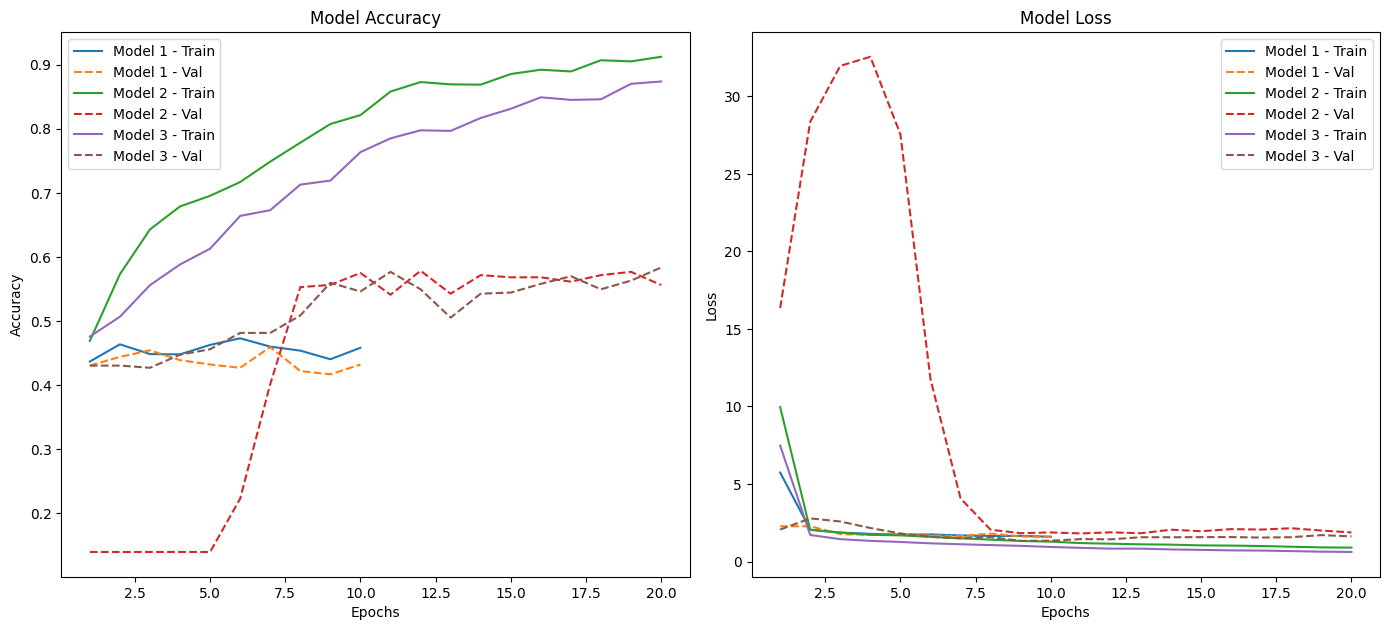

In [28]:
# Importing needed packages for visualization.
import matplotlib.pyplot as plt

# Create a dictionary to hold the accuracy and loss data
histories = {
    'Model 1': history_1.history,
    'Model 2': history_2.history,
    'Model 3': history_3.history
}

# Plotting
plt.figure(figsize=(14, 12))

# Plot Accuracy
plt.subplot(2, 2, 1)
for model, history in histories.items():
    epochs = range(1, len(history['accuracy']) + 1)  # Get the correct range of epochs
    plt.plot(epochs, history['accuracy'], label=f'{model} - Train')
    plt.plot(epochs, history['val_accuracy'], linestyle='--', label=f'{model} - Val')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(2, 2, 2)
for model, history in histories.items():
    epochs = range(1, len(history['loss']) + 1)  # Get the correct range of epochs
    plt.plot(epochs, history['loss'], label=f'{model} - Train')
    plt.plot(epochs, history['val_loss'], linestyle='--', label=f'{model} - Val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


We will continue to explore options for being able to run this in JupyterHub, but for now, this code was run on Kaggle.